# Students:

### Le Hoang Sang

### Vu Dinh Chuong

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# CLean data

In [34]:
def clean_data(df):
    print("Initial data information:")
    print(df.info())

    # Remove unnecessary columns (if there are columns named 'Unnamed')
    df = df.loc[:, ~df.columns.get_level_values(1).str.contains('^Unnamed')]

    # Handle the 'timestamp' column (if present)
    if ('timestamp', '') in df.columns:
        # Convert to datetime format
        df[('timestamp', '')] = pd.to_datetime(df[('timestamp', '')], errors='coerce')  
        
        # Remove rows with missing timestamp values
        df = df.dropna(subset=[('timestamp', '')]) 

    # Fill missing values using forward fill and backward fill methods
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize 'close' values between 0 and 1 if present
    if ('close', '') in df.columns:
        df[('close', '')] = (df[('close', '')] - df[('close', '')].min()) / (df[('close', '')].max() - df[('close', '')].min())

    # Print out the data after cleaning
    print("Data after cleaning:")
    print(df.head())

    return df


### Explain forward fill and backward fill methods

#### FFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 2, 2, 5]

=> 'NaN' values replaced with the previous valid value (2).

#### BFill
data = [1, 2, NaN, NaN, 5]

filled_data = [1, 2, 5, 5, 5]

=>'NaN' values replaced with the next valid value (5).

## Explain Min-max Normalization

normalized_value= (max_value − min_value) / (original_value − min_value)

​
Example:

close = [50, 55, 60, 65, 70]

min(x)=50
max(𝑥)=70

With value 60:
x_normalized = (60−50) / (70−50) = 10 / 20 = 0.5

# Create features

In the DataFrame: The dataset we re working with a MultiIndex data structure, where the first level of the index (such as 'A', 'AAL', etc.) represents the stock symbol, and the second level represents the attributes of the stock (such as 'close', 'open', 'high', etc.).

'A' is a stock symbol representing a specific company or asset.

Other symbols like 'AAL', 'ZION', etc., represent different companies or assets.

Why set symbol = 'A'?

In our code, setting symbol = 'A' focuses on the data of a specific company or asset. 

Since our DataFrame contains data for multiple stock symbols, we need to specify which stock symbol we want to use for feature generation.

In [35]:
def create_features(df):
    df_features = df.copy()

    print("Column names in the DataFrame:", df_features.columns)

    # Define the symbol you want to work with (e.g., 'A', 'AAL', etc.)
    symbol = 'A'

    # Define the columns for the selected stock symbol
    numeric_cols = [(symbol, 'open'), (symbol, 'high'), (symbol, 'low'), (symbol, 'close'), (symbol, 'volume')]

    # Check if these columns exist in the DataFrame
    existing_cols = [col for col in numeric_cols if col in df_features.columns]

    if not existing_cols:
        raise ValueError("Required numeric columns not found in the DataFrame.")

    # Convert the necessary columns to numeric type
    df_features[existing_cols] = df_features[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values after conversion
    df_features = df_features.dropna()

    # Create features if the necessary columns exist
    if (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'return')] = df_features[(symbol, 'close')].pct_change()
        df_features[(symbol, 'ma7')] = df_features[(symbol, 'close')].rolling(window=7).mean()
        df_features[(symbol, 'ma21')] = df_features[(symbol, 'close')].rolling(window=21).mean()
        df_features[(symbol, 'volatility')] = df_features[(symbol, 'close')].rolling(window=7).std()
    
    if (symbol, 'open') in df_features.columns and (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'open_close_ratio')] = df_features[(symbol, 'open')] / df_features[(symbol, 'close')]
    
    if (symbol, 'high') in df_features.columns and (symbol, 'low') in df_features.columns:
        df_features[(symbol, 'high_low_ratio')] = df_features[(symbol, 'high')] / df_features[(symbol, 'low')]

    # Remove rows with NaN values due to calculations
    df_features = df_features.dropna()  

    print("DataFrame with new features:")
    print(df_features.head())

    return df_features

# Plot data

In [36]:
def plot_features(df_features, symbol='A'):
    # Ensure symbol exists in the DataFrame
    if symbol not in df_features.columns.get_level_values(0):
        raise ValueError(f"Symbol '{symbol}' not found in DataFrame columns.")

    # Plot the 'close' price
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'close')], label=f'{symbol} Close Price', color='b')
    plt.title(f'{symbol} Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Plot the 7-day and 21-day moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'ma7')], label=f'{symbol} MA7', color='g')
    plt.plot(df_features.index, df_features[(symbol, 'ma21')], label=f'{symbol} MA21', color='r')
    plt.title(f'{symbol} 7-day and 21-day Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot the volatility (7-day rolling standard deviation)
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'volatility')], label=f'{symbol} Volatility (7-day)', color='purple')
    plt.title(f'{symbol} Volatility (7-day rolling std)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # Plot the open/close ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'open_close_ratio')], label=f'{symbol} Open/Close Ratio', color='orange')
    plt.title(f'{symbol} Open/Close Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

    # Plot the high/low ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'high_low_ratio')], label=f'{symbol} High/Low Ratio', color='brown')
    plt.title(f'{symbol} High/Low Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

# Run flow

In [37]:
df = pd.read_csv('dataset.csv', index_col=0, header=[0, 1]).sort_index(axis=1)

In [38]:
df_cleaned = clean_data(df)

print(df_cleaned.head())

Initial data information:
<class 'pandas.core.frame.DataFrame'>
Index: 43146 entries, 2017-09-11 09:30:00 to 2018-02-16 15:59:00
Columns: 2510 entries, ('A', 'close') to ('ZTS', 'volume')
dtypes: float64(2510)
memory usage: 826.6+ MB
None
Data after cleaning:
                         A                                      AAL         \
                     close   high      low     open   volume  close   high   
timestamp                                                                    
2017-09-11 09:30:00  65.46  65.50  65.4100  65.5000  29852.0  44.01  44.05   
2017-09-11 09:31:00  65.46  65.50  65.4100  65.5000  29852.0  44.25  44.25   
2017-09-11 09:32:00  65.66  65.66  65.4604  65.4604   3435.0  44.27  44.32   
2017-09-11 09:33:00  65.69  65.70  65.6200  65.6700    700.0  44.34  44.46   
2017-09-11 09:34:00  65.88  65.88  65.6800  65.6900   2814.0  44.24  44.36   

                                              ...   ZION                       \
                         low   ope

Column names in the DataFrame: MultiIndex([(   'A',  'close'),
            (   'A',   'high'),
            (   'A',    'low'),
            (   'A',   'open'),
            (   'A', 'volume'),
            ( 'AAL',  'close'),
            ( 'AAL',   'high'),
            ( 'AAL',    'low'),
            ( 'AAL',   'open'),
            ( 'AAL', 'volume'),
            ...
            ('ZION',  'close'),
            ('ZION',   'high'),
            ('ZION',    'low'),
            ('ZION',   'open'),
            ('ZION', 'volume'),
            ( 'ZTS',  'close'),
            ( 'ZTS',   'high'),
            ( 'ZTS',    'low'),
            ( 'ZTS',   'open'),
            ( 'ZTS', 'volume')],
           length=2510)
DataFrame with new features:
                          A                                     AAL          \
                      close    high     low     open  volume  close    high   
timestamp                                                                     
2017-09-11 09:50:00  6

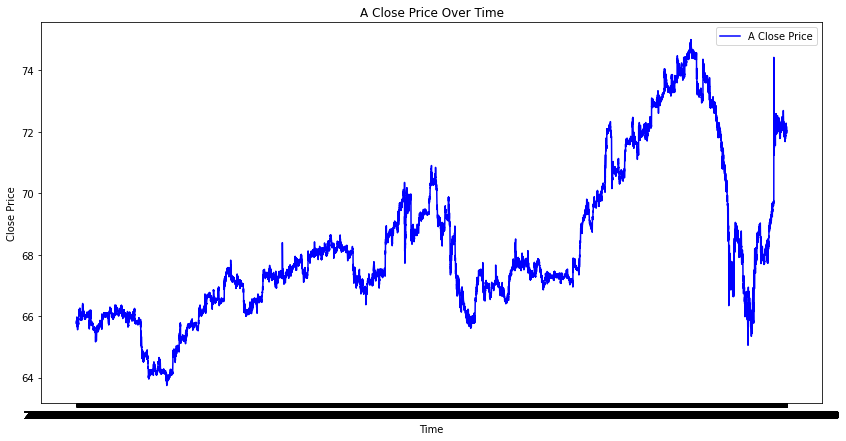

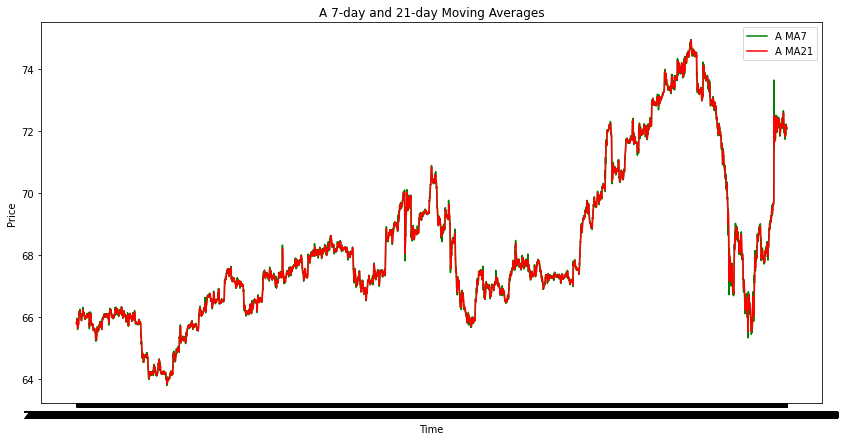

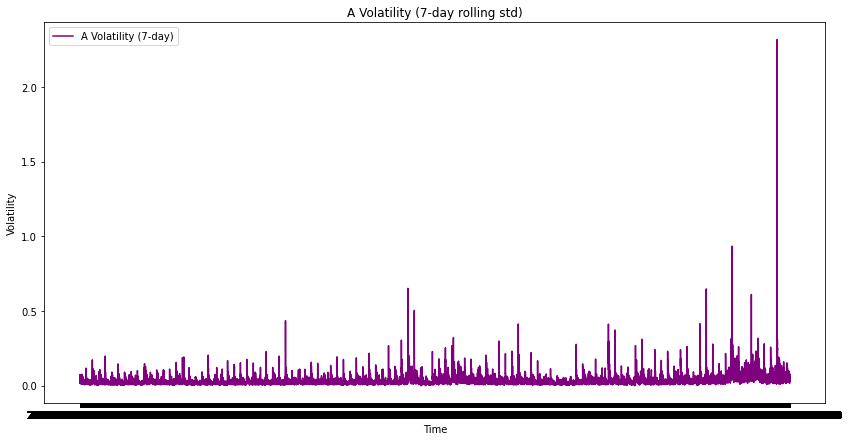

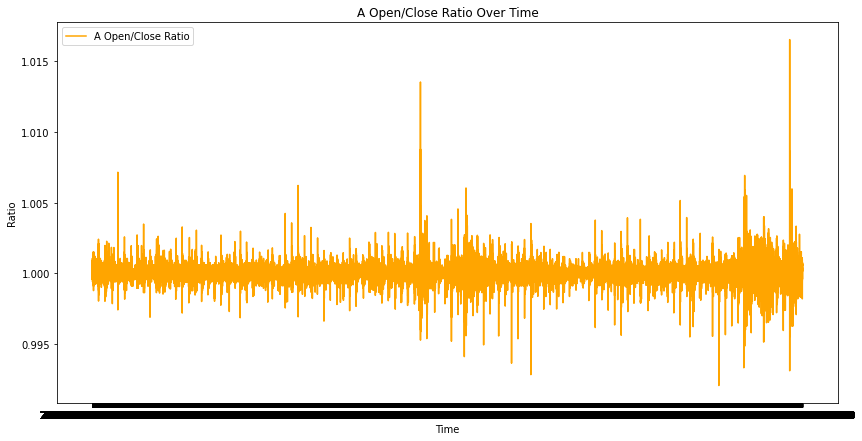

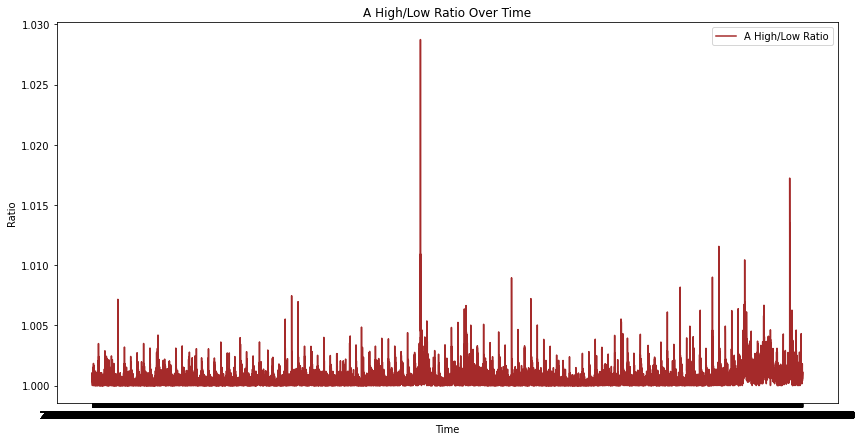

In [39]:
df_features = create_features(df_cleaned)

print('features', df_features.head())

plot_features(df_features, symbol='A')